**Name:** David Björelind

**EID:** 40107147

# CS4487 - Tutorial 8
## Non-Linear Dimensionality Reduction and Face Recognition

In this tutorial you will use non-linear dimensionality reduction on face images, and then train a classifier for face recognition.  You will then use manifold embedding to visualize the data.

First we need to initialize Python.  Run the below cell.

In [57]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
random.seed(100)
rbow = plt.get_cmap('rainbow')

## Loading Data and Pre-processing
We first need to load the images.  We will use the same dataset as Tutorial 7. Download `olivetti_py3.pkz` from Canvas, and place it in in the same directory as this ipynb file.  _DO NOT UNZIP IT_.  Then run the following cell to load the images.

In [58]:
oli = datasets.fetch_olivetti_faces(data_home="./")
X = oli.data
Y = oli.target
img = oli.images
imgsize = oli.images[0].shape

Each image is a 64x64 array of pixel values, resulting in a 4096 dimensional vector.  Run the below code to show all the images!

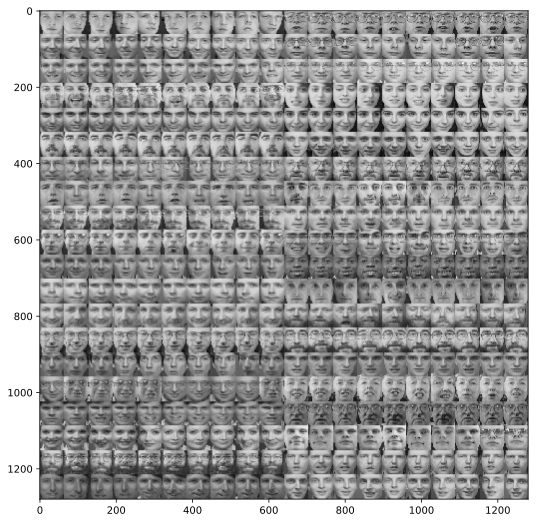

In [59]:
tmp = []
for i in range(0,400,20):
    tmp.append( hstack(img[i:i+20]) )
allimg = vstack(tmp)
plt.figure(figsize=(9,9))
plt.imshow(allimg, cmap='gray', interpolation='nearest')
plt.show()

Each person is considered as one class, and there are 10 images for each class.  In total there are 40 classes (people).  The data is already vectorized and put into the matrix `X`. Now we split the data into training and testing sets.

In [60]:
# randomly split data into 80% train and 20% test set
trainX, testX, trainY, testY = \
  model_selection.train_test_split(X, Y, 
  train_size=0.80, test_size=0.20, random_state=4487)

print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(320, 4096)
(80, 4096)
(320,)
(80,)


# Non-Linear Dimensionality Reduction - KPCA
The dimension of the data is too large (4096) so learning classifiers will take a long time.  Instead, our strategy is to use KPCA to reduce the dimension first and then use the KPCA weights as the representation for each image.  Run KPCA on the data using 10 principal components.  Use the RBF kernel with gamma=0.001.

In [61]:
### INSERT YOUR CODE HERE
## Reducing the data down to 10 instead of 4096, also tranforming the test data
kpca = decomposition.KernelPCA(n_components=10, kernel='rbf', gamma=0.001)
trainX_10 = kpca.fit_transform(trainX)
testX_10 = kpca.transform(testX)

In [62]:
print(trainX.shape)
print(trainX_10.shape)
print(testX.shape)
print(testX_10.shape)

(320, 4096)
(320, 10)
(80, 4096)
(80, 10)


The below function will plot the basis vectors of KPCA. Run the next 2 cells to view the PCs.  The kernel PCs are a combination of similarities to points in the training set.  The PCs are visualized by showing the top 5 positive and negative training examples, along with their coefficient $\alpha_i$.

In [63]:
def plot_kbasis(model, imgsize, X):
    KK = model.n_components
    alphas = model.alphas_.T
    minmax = 5
    
    py = KK
    px = minmax*2
    for i in range(KK):
        # sort alphas
        inds = argsort(alphas[i,:])

        myi = r_[arange(-1,-minmax-1,-1), arange(minmax-1,-1,-1)]
        myinds = inds[myi]
        
        for j,jj in enumerate(myinds):
            plt.subplot(py,px,(j+1)+i*px)
            plt.imshow(X[jj,:].reshape(imgsize), interpolation='nearest')
            plt.gray()
            if alphas[i,jj]<0:
                mycol = 'b'
            else:
                mycol = 'r'
            plt.title("{:.3f}".format(alphas[i,jj]), fontsize=7, color=mycol)
            if (j==0):
                plt.ylabel('PC' + str(i+1))
            plt.xticks([])
            plt.yticks([])

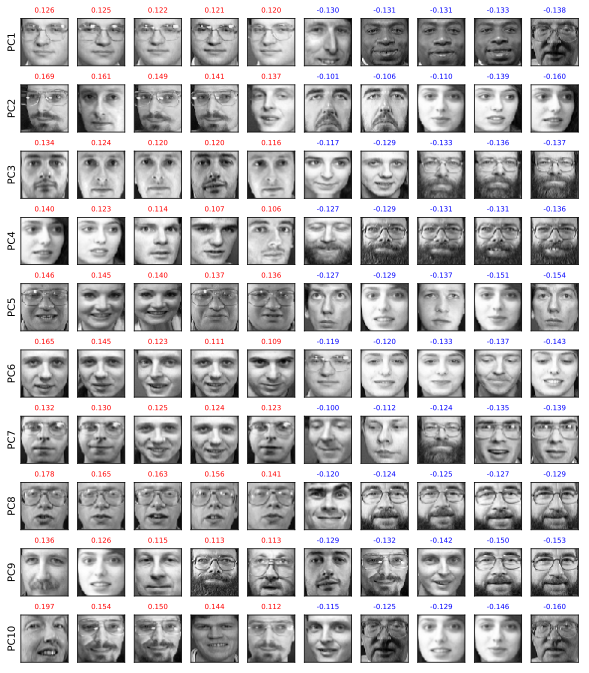

In [64]:
# run the function
plt.figure(figsize=(10,12))
plot_kbasis(kpca, imgsize, trainX)

_What is the interpretation for the KPCA basis?  What kind of faces do some of the PCs prefer?_
- **INSERT YOUR ANSWER HERE**

I think most of the PC:s are very unclear on what features they prefer
PC1: Prefering lighter and brighter pictures
PC4: Prefering a face without beard
PC6: Looks for shadows in the face, dislikes no shadows in the picture

I thought that some PC would be able to detect glasses, but apparently not.

PC9 just looks like random pictures to me, I cannot declare any clear differences.


### Face Recognition
Now train a _linear_ classifier to do the face recognition.  Use the calculated KPCA representation as the new set of inputs.  Use cross-validation to set the hyperparameters of the classifier.  You do not need to do cross-validation for the number of components or kernel hyperparameters.  Calculate the average training and testing accuracies.  Remember to transform the test data into the KPCA representation too!

**NOTE**: It is **NOT** recommended to use `svm.SVC` for the training.  This is because the default SVC implements 1-vs-1 multi-class classification, which means it will calculate 40x39=1560 classifiers!  All other classifier should be fine since they do 1-vs-all multi-class classification, e.g., LogisticRegressionCV, LinearSVC, etc.  If you want to use svm.SVC, make sure to use the OneVsRestClassifier as shown in Lecture 3.

In [65]:
### INSERT YOUR CODE HERE

print(trainX_10.shape)
print(trainX.shape)
#print(testX_10.shape)
print(testX.shape)

## Training a classifier
logreg = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, n_jobs=-1)
logreg.fit(trainX_10, trainY)




(320, 10)
(320, 4096)
(80, 4096)


LogisticRegressionCV(Cs=array([1.00000e-04, 2.63665e-04, 6.95193e-04, 1.83298e-03, 4.83293e-03,
       1.27427e-02, 3.35982e-02, 8.85867e-02, 2.33572e-01, 6.15848e-01,
       1.62378e+00, 4.28133e+00, 1.12884e+01, 2.97635e+01, 7.84760e+01,
       2.06914e+02, 5.45559e+02, 1.43845e+03, 3.79269e+03, 1.00000e+04]),
           class_weight=None, cv=5, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=-1, penalty='l2', random_state=None, refit=True,
           scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [66]:
# predict from the model
predYtest = logreg.predict(testX_10)
predYtrain = logreg.predict(trainX_10)


# calculate accuracy
acctest = metrics.accuracy_score(testY, predYtest)
acctrain = metrics.accuracy_score(trainY, predYtrain)

print("test accuracy =", acctest)
print("train accuracy =", acctrain)


test accuracy = 0.725
train accuracy = 0.928125


### Finding the best kernel and best number of components
Now try different kernels (poly, RBF, etc), kernel parameters, and number of components to get the best test accuracy.  Train a classifier for each one and see which dimension gives the best testing accuracy.  Make a plots of number of components vs. test accuracy.

In [67]:
# doing tests for RBF Kernel
gammarange = logspace(-4, -1, 10)
accuracyRBF = []

for i in gammarange:
    
    kpca = decomposition.KernelPCA(n_components=10, kernel='rbf', gamma=i)
    trainX_10 = kpca.fit_transform(trainX)
    testX_10 = kpca.transform(testX)
    ## Training a classifier
    logreg = linear_model.LogisticRegressionCV(Cs=logspace(-3,3,10), cv=4, n_jobs=-1)
    logreg.fit(trainX_10, trainY)
    #Calculating test accuracy
    predYtest = logreg.predict(testX_10)
    acctest = metrics.accuracy_score(testY, predYtest)
    #Putting accuracy into list
    accuracyRBF.append(acctest)
   

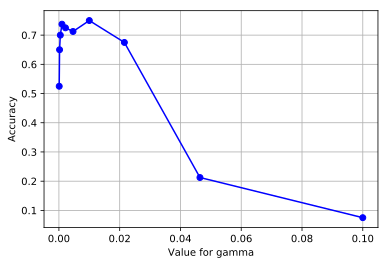

0.75


In [68]:
# Showing plot

x = gammarange
y = accuracyRBF
plt.plot(x, y, "bo-")
plt.xlabel('Value for gamma')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()
print(max(accuracyRBF)) # when gamma = 0.01

In [120]:
# Doing tests for poly kernel
gammarange = logspace(-3, 0, 10)
degreerange = [4, 5, 6, 7]
accuracyPOLY = []

for g in gammarange:
    for d in degreerange:
        kpca = decomposition.KernelPCA(n_components=10, kernel='poly', gamma = g, degree = d, coef0 = 0)
        trainX_10 = kpca.fit_transform(trainX)
        testX_10 = kpca.transform(testX)
        ## Training a classifier
        logreg = linear_model.LogisticRegressionCV(Cs=logspace(-2,3,8), cv=4, n_jobs=-1)
        logreg.fit(trainX_10, trainY)
        #Calculating test accuracy
        predYtest = logreg.predict(testX_10)
        acctest = metrics.accuracy_score(testY, predYtest)
        #Putting accuracy into list
        accuracyPOLY.append(acctest)

In [122]:
# Getting the best parameters

gammaindex = 0
degreeindex = 0
top = 0
for i in range(0, len(accuracyPOLY)):
    if accuracyPOLY[i] > top:
        top = accuracyPOLY[i]
        gammaindex = round((i+1)/len(degreerange))
        degreeindex = (i+1)%len(degreerange)
        
print("gamma: ",gammarange[gammaindex],", degree: ",degreerange[degreeindex],", Top accuracy: ", top)
    

gamma:  0.01 , degree:  5 , Top accuracy:  0.8


_What is the best kernel and number of components?  View the prototypes for each compenent to see what they look like_
- **INSERT YOUR ANSWER HERE**

POLY Kernel got the highest accuracy with gamma = 0.01 and degree = 5

In [124]:
### INSERT YOUR CODE HERE
kpca = decomposition.KernelPCA(n_components=10, kernel='poly', gamma = 0.01, degree = 5, coef0 = 0)
trainX_10 = kpca.fit_transform(trainX)
testX_10 = kpca.transform(testX)
        ## Training a classifier
logreg = linear_model.LogisticRegressionCV(Cs=logspace(-2,3,8), cv=4, n_jobs=-1)
logreg.fit(trainX_10, trainY)
        #Calculating test accuracy
predYtest = logreg.predict(testX_10)
acctest = metrics.accuracy_score(testY, predYtest)
        #Putting accuracy into list
accuracyPOLY.append(acctest)

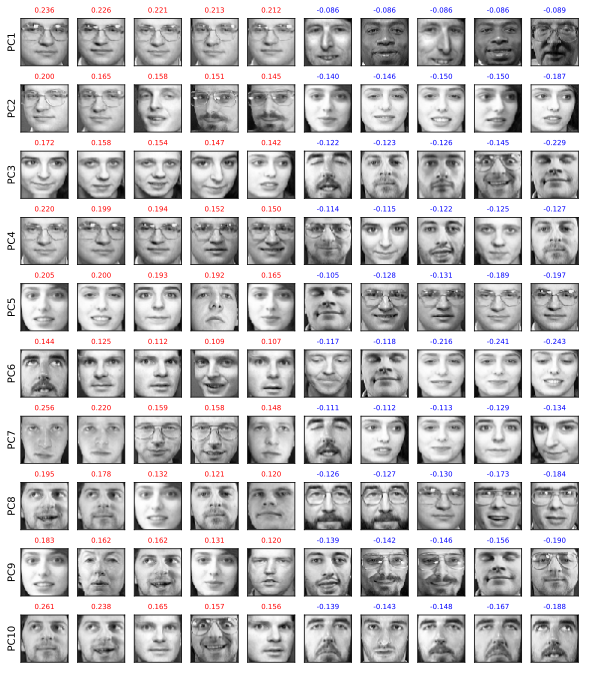

In [125]:
plt.figure(figsize=(10,12))
plot_kbasis(kpca, imgsize, trainX)

# Manifold embedding
Now you will use manifold embedding to visualize the dataset.
Use various methods to embed the data into 2 dimensions.  Use the below function to plot the low-dimensional data. **Note:** use the whole dataset `X` to do the embedding.

In [154]:
def plot_embedding(X, Y, title=None):
    # X is the low-dim data
    zoomfact = 0.30  # change this to make images bigger/smaller
    
    x_min, x_max = amin(X, 0), amax(X, 0)
    X = (X - x_min) / (x_max - x_min)
    ax = plt.gca()

    plt.scatter(X[:,0], X[:,1], c=Y, cmap=rbow, edgecolor="")
    
    if hasattr(matplotlib.offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = array([[1., 1.]])  # just something big
        for i in range(img.shape[0]):
            dist = sum((X[i] - shown_images) ** 2, 1)
            if min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = r_[shown_images, [X[i]]]
            imagebox = matplotlib.offsetbox.AnnotationBbox(
                matplotlib.offsetbox.OffsetImage(img[i], 
                    zoom=zoomfact, 
                    cmap=plt.cm.gray), X[i], pad=0.02)
            imagebox.patch.set_edgecolor(rbow(Y[i]/max(Y)))
            imagebox.patch.set_linewidth(2)
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

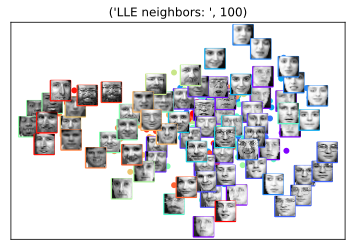

In [178]:
### INSERT YOUR CODE HERE
## Let's start by using LLE.

nn = 100
lle = manifold.LocallyLinearEmbedding(n_neighbors=nn, n_components=2, random_state=121, n_jobs=-1)
Xr = lle.fit_transform(X)
## Plotting transformed data
plot_embedding(Xr, Y,("LLE neighbors: ", nn))

## It seems that the images are pretty cluttered together, and not very much order

/Users/davidbjorelind/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


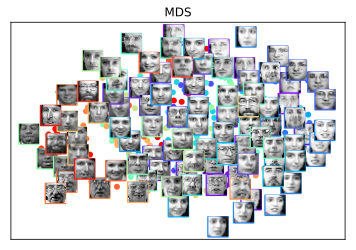

In [179]:
##Continuing with MDS

mds = manifold.MDS(n_components=2, random_state=1234, n_jobs=-1)
Xr = mds.fit_transform(X)
## Plotting transformed data
plot_embedding(Xr, Y,"MDS")

## I feel like MDS did a better job than LLE to put simular faces next to each other
## The problems with MDS does not seem to be present in this case

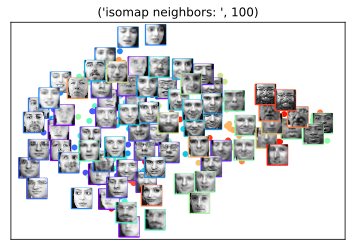

In [180]:
## Continuing with isomap
nn = 100
iso = manifold.Isomap(n_neighbors = nn, n_components=2, n_jobs=-1)
Xr = iso.fit_transform(X)

plot_embedding(Xr, Y,("isomap neighbors: ", nn))

## isomap performed better than LLE but worse than DMS. Hopefully I am using a good number of neighbors for those


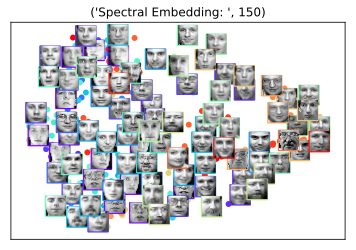

In [181]:
## continuing with Spectral Embedding
nn = 150
spe = manifold.SpectralEmbedding(n_components=2, affinity='nearest_neighbors',random_state=1234, 
                                 n_neighbors=nn, n_jobs=-1)
Xr = spe.fit_transform(X)

plot_embedding(Xr, Y,("Spectral Embedding: ", nn))

## Spectral Embedding looks on par with MDS, maybe a little bit behind

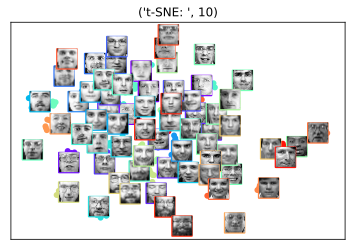

In [182]:
## Last but not least: t-SNE
# I think that perplexity should be 10 as there are 10 pictures of each person -> group of 10

px = 10
tsne = manifold.TSNE(n_components=2, perplexity=px, random_state=11)
Xr = tsne.fit_transform(X)

plot_embedding(Xr, Y,("t-SNE: ", px))

## t-SNE performed as well as the other methods I think. Although, the representation looks a bit different

_Which embedding looks the best in terms of preserving structure of the data (similarity between images)?_
- **INSERT YOUR ANSWER HERE**

The number of neighbors has a drastic impact on the shape of the embedded data.
I used mostly the same number of neighbors for all of the methods.

None of the methods were drastically worse or better than the others. All in all they were pretty simular.
Shared first place goes to: MDS and t-SNE.

I think that t-SNE managed get most of the people into it's own group, as supposed to MDS that really managed to find simularities between faces of different people. Maybe this feature of the t-SNEcan be called overfitting?

